In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import warnings 

In [3]:
train  = pd.read_csv('train_tweets.csv')
test = pd.read_csv('test_tweets.csv')

In [4]:
train.head(2)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...


In [6]:
test.head(2)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...


In [7]:
train.shape

(31962, 3)

In [8]:
test.shape

(17197, 2)

In [11]:
combine = train.append(test, ignore_index=True)


In [14]:
#  remove twitter handle
combine['tweet'] = combine['tweet'].apply(lambda x : re.sub('@[\w*]', '', x))


In [17]:
# combine.head(2)
combine['tweet'] = combine['tweet'].str.replace("[^a-zA-Z#]", " ")

C:\Users\NEHACH~1\AppData\Local\Temp/ipykernel_6668/1473863601.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  combine['tweet'] = combine['tweet'].str.replace("[^a-zA-Z#]", " ")


In [19]:
combine['tweet'] = combine['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [20]:
tokenized_tweet = combine['tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tweet, dtype: object

In [21]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tweet, dtype: object

In [22]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combine['tweet'] = tokenized_tweet

In [23]:
combine.head()

,id,label,tweet
0,1,0.0,when father dysfunct selfish drag kid into dys...
1,2,0.0,thank #lyft credit caus they offer wheelchair ...
2,3,0.0,bihday your majesti
3,4,0.0,#model love take with time
4,5,0.0,factsguid societi #motiv


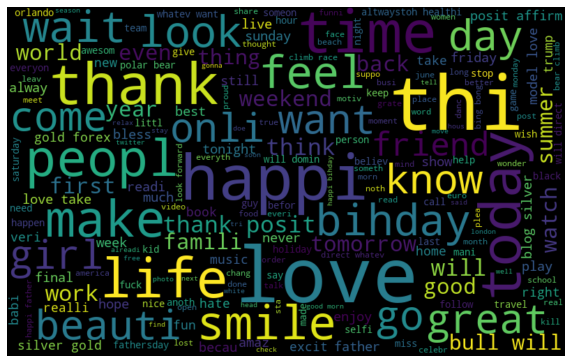

In [25]:
all_words = ' '.join([text for text in combine['tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

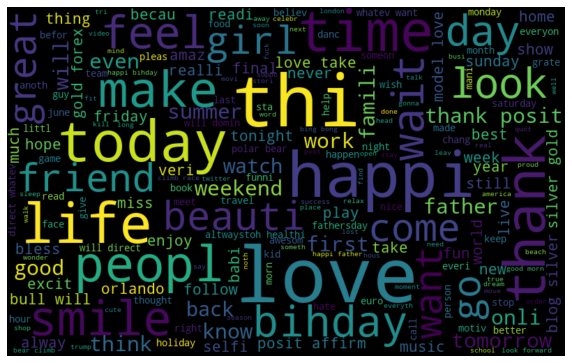

In [26]:
normal_words =' '.join([text for text in combine['tweet'][combine['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [28]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [30]:

HT_regular = hashtag_extract(combine['tweet'][combine['label'] == 0])

HT_negative = hashtag_extract(combine['tweet'][combine['label'] == 1])

HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

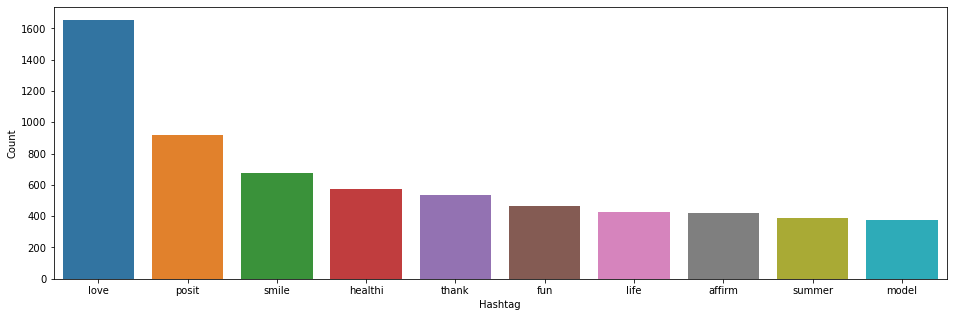

In [31]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

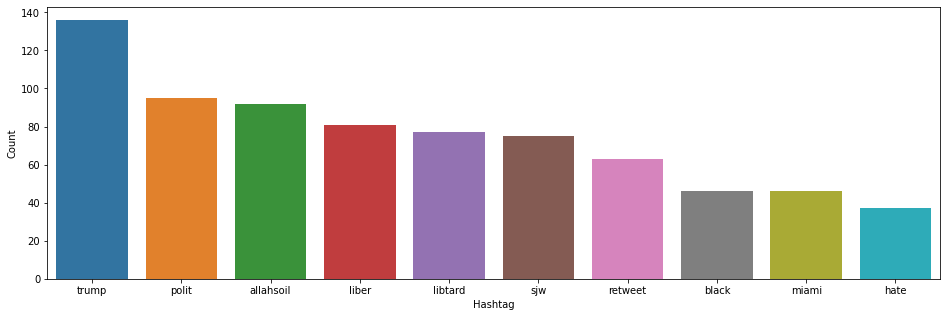

In [33]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combine['tweet'])

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combine['tweet'])

In [40]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) 

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

C:\Users\NEHACH~1\AppData\Local\Temp/ipykernel_6668/526121969.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


0.5303408146300915

In [41]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False)

C:\Users\NEHACH~1\AppData\Local\Temp/ipykernel_6668/3885775721.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_pred_int = test_pred_int.astype(np.int)


<9589x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 37685 stored elements in Compressed Sparse Row format>